In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [ ]:
# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [ ]:
# Config
SUB_FILE_NAME = "val10-2"
SAVE_SUB = True
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SAVE_DF = False
SAVE_DF_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/Val_20230429")

# データ読み込み

In [ ]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")

# 特徴抽出後のデータ
umap_basic_train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_train.pkl")
umap_basic_test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_test.pkl")
train_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_sentinel_minmaxDiff.pkl")
test_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_sentinel_minmaxDiff.pkl")
train_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_train_landsat2_2000to2020.pkl")
test_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_test_landsat2_2000to2020.pkl")
train_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_landsat_minmax.pkl")
test_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_landsat_minmax.pkl")

train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [ ]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

## 対数変換

In [ ]:
train[f"log_cover"] = np.log1p(train["cover"])

## 特徴抽出後のデータを結合

In [ ]:
print(train.shape)
print(train_landsat_minmax.shape)
print(test.shape)
print(test_landsat_minmax.shape)
train_landsat_minmax.head(2)

(14140, 3465)
(14140, 50)
(4039, 3463)
(4039, 50)


,MINMAX_MVI,MINMAX_Chlred_edge,MINMAX_NLI,MINMAX_IF,MINMAX_GEMI,MINMAX_Chlgreen,MINMAX_CVI,MINMAX_DSWI_5,MINMAX_TSAVI,MINMAX_PSNDc2,...,MINMAX_EVI,MINMAX_GVMI,MINMAX_RDVI,MINMAX_PPR,MINMAX_SIPI2,MINMAX_Cigreen,MINMAX_D678_500,MINMAX_DVIMSS,MINMAX_Green,MINMAX_Alteration
0,-0.498732,-0.031920,1.075848,1.225176,0.018427,0.065996,0.91124,0.839658,1.035656,1.000000,...,0.558870,0.176156,0.345818,1.035576,0.350692,0.960665,-0.223362,1.000000,1.052035,3.30233
1,0.698608,1.080161,-0.089137,-1.235533,0.525556,1.083810,-0.57457,-0.393703,-0.195017,-0.575291,...,2.011747,0.262679,-0.418989,-0.841783,0.968533,-0.482458,-0.112053,-1.535718,-0.357916,-0.12575


In [ ]:
train = train.join([
    umap_basic_train,
    train_sentinel,
    train_landsat_minmax,
    train_landsat_2000to2020,
])
test = test.join([
    umap_basic_test,
    test_sentinel,
    test_landsat_minmax,
    test_landsat_2000to2020,
])
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MINMAX_MCARI2__mean,MINMAX_MCARI2__std,MED_NormR_median,MED_NormR_std,MINMAX_NormR__mean,MINMAX_NormR__std,MED_TIRS2_median,MED_TIRS2_std,MINMAX_TIRS2__mean,MINMAX_TIRS2__std
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-0.006201,1.087738,0.222131,0.699859,-0.086431,1.010979,0.470200,0.632177,-0.219153,0.892955
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,-0.775479,0.251864,0.904064,1.205264,-0.222484,0.889441,-0.002017,0.795383,-0.719698,0.899809


In [ ]:
umap_basic_train.head()

,dim0,dim1,temp_monthly
0,1.788618,6.597842,27.9
1,-10.111396,6.170877,29.2
2,21.165592,6.679852,25.3
3,-6.996612,9.728025,16.7
4,-6.822807,9.109682,16.7


## 使用する特徴量

In [ ]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
cols_landsat = train.columns.to_list()[25:88]
cols_landsat_2000to2020 = train_landsat_2000to2020.columns.to_list()
cols_landsat_minmax = train_landsat_minmax.columns.to_list()

cols_sentinel = train.columns.to_list()[88:313]
cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_sentinel_minmax = train_sentinel.columns.to_list()

cols_umap = ["temp_monthly"]

cols_use =\
 cols_base +\
 cols_landsat +\
 cols_landsat_2000to2020 +\
 cols_landsat_minmax +\
 cols_sentinel +\
 cols_sentinel_minmax +\
 ["log_cover"] # + cols_sentinel

cols_remove = [
    "YMD",
    "month",
    "Date_Acquired",
    "Landsat_StartTime",
    "PRODUCT_ID",
    "mesh20"
]
cols_use = [col for col in cols_use if not col in cols_remove]

# 重複を省く（一応）
cols_use = list(set(cols_use))

cols_use

['MINMAX_SWIR2__mean',
 'depth',
 'MINMAXDiff_B02',
 'MED_TIRS2_std',
 'MED_TIRS2_median',
 'MED_MCARI2_median',
 'MED_Green_median',
 'MED_BNDVI',
 'MED_GVMI_std',
 'MINMAX_H',
 'hist_cold_sst',
 'MSAVI',
 'MED_mCRIRE_std',
 'Landsat_num',
 'MINMAX_PPR__std',
 'MED_GEMI_median',
 'log_cover',
 'Chlred_edge',
 'area',
 'GEMI',
 'MED_PPR_median',
 'MINMAX_Alteration',
 'MED_TSAVI_std',
 'MINMAX_SIPI2__std',
 'MCARI2',
 'sunAzimuth',
 'MED_SWIR1_std',
 'Ferrous_Silicates',
 'MINMAX_EVI__std',
 'MED_SLAVI_median',
 'MINMAX_GLI__std',
 'MED_CI_median',
 'MINMAXDiff_CIrededge',
 'MED_Gossan_median',
 'MINMAXDiff_IF',
 'MED_SB550',
 'MED_Rededge1',
 'MED_RDVI_std',
 'MED_Ferrous_Silicates_median',
 'MINMAX_Green__mean',
 'MINMAXDiff_B8A',
 'Red',
 'MINMAX_mCRIG',
 'DSWI',
 'MED_H_median',
 'MINMAX_Chlred_edge',
 'MED_NBR2',
 'Cirededge',
 'MED_Chlred_edge_std',
 'MINMAX_D678_500__std',
 'Chlgreen',
 'MED_GVMI',
 'MINMAXDiff_PSSRc2',
 'MED_TCI',
 'MINMAXDiff_CARI',
 'GLI',
 'MINMAX_NIR',
 'MI

In [ ]:
train = train[cols_use]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Columns: 482 entries, MINMAX_SWIR2__mean to MED_NormG_std
dtypes: float32(232), float64(250)
memory usage: 39.5 MB


In [ ]:
cols_obj = ["cover", "log_cover"]
features = [col for col in cols_use if col not in cols_obj]
print("特徴量の数：", len(features))

特徴量の数： 480


In [ ]:
corr = train[features].corr()
threshold = 0.98
drop_numeric_cols=[]
pair=[]
for col in features:
    # if col in cat_features:
    #     continue
    for i in range(len(corr)):
        if abs(corr[col].iloc[i]) >= threshold and col != features[i] :
            print(f"{col} and {features[i]} are highly correlated...") 
            if col not in pair:
                pair.append(col)
                pair.append(features[i])
                drop_numeric_cols.append(col) 
features = list(set(features)-set(drop_numeric_cols))
print(f"Dropping columns : {drop_numeric_cols}")
print("特徴量の数：", len(features))
del drop_numeric_cols
del pair

features

MINMAX_SWIR2__mean and MINMAX_SWIR1__mean are highly correlated...
MSAVI and Chlred_edge are highly correlated...
Chlred_edge and MSAVI are highly correlated...
MED_SB550 and MED_B03 are highly correlated...
MINMAXDiff_B8A and MINMAXDiff_B07 are highly correlated...
MINMAXDiff_B8A and MINMAXDiff_B06 are highly correlated...
MED_TCI and MED_BB1 are highly correlated...
MED_TCI and MED_B04 are highly correlated...
NBR and GVMI are highly correlated...
cold_sst and lon are highly correlated...
cold_sst and lat are highly correlated...
cold_sst and sst_annual are highly correlated...
MED_CVI_median and MED_Cigreen_median are highly correlated...
MINMAX_TSAVI and MINMAX_Cirededge are highly correlated...
MINMAX_BWDRVI__mean and MINMAX_PSNDc2__mean are highly correlated...
CVI and BWDRVI are highly correlated...
CVI and Cigreen are highly correlated...
MINMAXDiff_NDVI2 and MINMAXDiff_NDII are highly correlated...
MINMAXDiff_NDVI2 and MINMAXDiff_NDBI are highly correlated...
MINMAXDiff_RDI an

['depth',
 'MINMAXDiff_B02',
 'MED_TIRS2_std',
 'MED_VARIgreen_median',
 'MED_TIRS2_median',
 'MED_PPR_std',
 'MED_MCARI2_median',
 'MED_MCARI_MTVI2',
 'MINMAX_DSWI__mean',
 'MED_Green_median',
 'MED_BNDVI',
 'MED_GVMI_std',
 'MINMAX_H',
 'hist_cold_sst',
 'MINMAX_Chlred_edge__std',
 'MED_mCRIRE_std',
 'Landsat_num',
 'MINMAX_TIRS1',
 'MINMAX_PPR__std',
 'MED_GEMI_median',
 'MINMAX_GARI__mean',
 'Chlred_edge',
 'MINMAXDiff_CIgreen',
 'MED_GARI_median',
 'GEMI',
 'area',
 'NIR',
 'MED_TIRS1_std',
 'MINMAX_PSNDc2',
 'MED_PPR_median',
 'MINMAX_Alteration',
 'MED_TSAVI_std',
 'MINMAX_DSWI_5__std',
 'MINMAX_SIPI2__std',
 'sunElevation',
 'MINMAXDiff_B07',
 'MCARI2',
 'MINMAX_Cigreen__std',
 'sunAzimuth',
 'MED_SWIR1_std',
 'MINMAX_Chlgreen__std',
 'MINMAX_AVI__std',
 'MINMAXDiff_ARI',
 'Ferrous_Silicates',
 'MINMAX_EVI__mean',
 'MED_MCARI2_std',
 'MED_AVI_median',
 'MINMAXDiff_NDII',
 'MINMAX_EVI__std',
 'MINMAXDiff_MIRBI',
 'MINMAX_NormR',
 'MED_SLAVI_median',
 'MINMAX_GLI__std',
 'MED_IF'

# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [ ]:
# train_date = train[["year", "month"]].copy()

# def convert_int_into_str(x):
#     x_str = str(int(x))
#     if len(x_str)==1:
#         return "0" + x_str
#     return x_str

# train_date["month_str"] = train_date["month"].apply(convert_int_into_str)
# train_date["year_month"] = (train_date["year"].astype(int).astype(str) + train_date["month_str"]).astype(int)
# train_date.head()

In [ ]:
# year_month = train_date["year_month"]
# cv = []

# val_idx1 = (year_month >= 200901)&(year_month <200907)
# train_idx1 = ~val_idx1
# cv.append([train_idx1, val_idx1])

# val_idx2 = (year_month >= 200910)&(year_month <200912)
# train_idx2 = ~val_idx2
# cv.append([train_idx2, val_idx2])

# val_idx3 = (year_month >= 201006)&(year_month <201009)
# train_idx3 = ~val_idx3
# cv.append([train_idx3, val_idx3])

# val_idx4 = (year_month >= 201010)&(year_month <201101)
# train_idx4 = ~val_idx4
# cv.append([train_idx4, val_idx4])

# val_idx5 = (year_month >= 201909)&(year_month <201910)
# train_idx5 = ~val_idx5
# cv.append([train_idx5, val_idx5])

In [ ]:
def my_cross_val_predict(df, df_test, y_name=None, y_raw_name=None, params=None, features=None, cv=None, split=5, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    kfold = KFold(n_splits=split, shuffle=True, random_state=42)
    X = df[features].values
    y = df[y_name].values
    y_raw = df[y_raw_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    y_pred_val_all = np.zeros(len(y))
    y_pred_val_all[:] = np.nan

    for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]
        y_val_raw = y_raw[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            lgb.early_stopping(100),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred_raw = model.predict(X_val)
        y_pred = np.expm1(y_pred_raw)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        print(np.average(y_pred))
        y_pred_val_all[val_idx] = y_pred
        # testデータ予測
        y_pred_test_raw = model.predict(X_test)
        y_pred_test = np.expm1(y_pred_test_raw)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / split)
        
        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val_raw, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val_raw, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['fair'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean, y_pred_val_all

In [ ]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [ ]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 9,
    'n_estimators': 2000,
    'learning_rate': 0.01,
    # 'num_leaves': 50,
    # 'colsample_bytree': 0.6,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

## パターン1（depth_originalが欠損）

In [ ]:
# 最終的なスコアを入れるやつ
y_test_pred_final = np.zeros(len(test))
y_test_pred_final[:] = np.nan
y_val_pred_final = np.zeros(len(train))
y_val_pred_final[:] = np.nan

##############################
● CV0
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00193381
[1000]	valid_0's fair: 0.00182814
[1500]	valid_0's fair: 0.00178952
[2000]	valid_0's fair: 0.00176518
Did not meet early stopping. Best iteration is:
[2000]	valid_0's fair: 0.00176518
0.15241465097650034


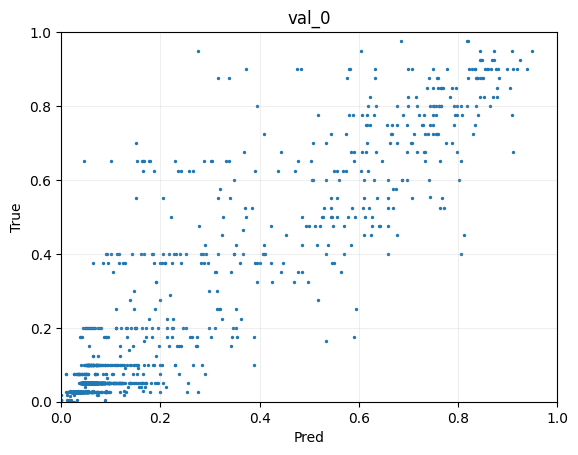

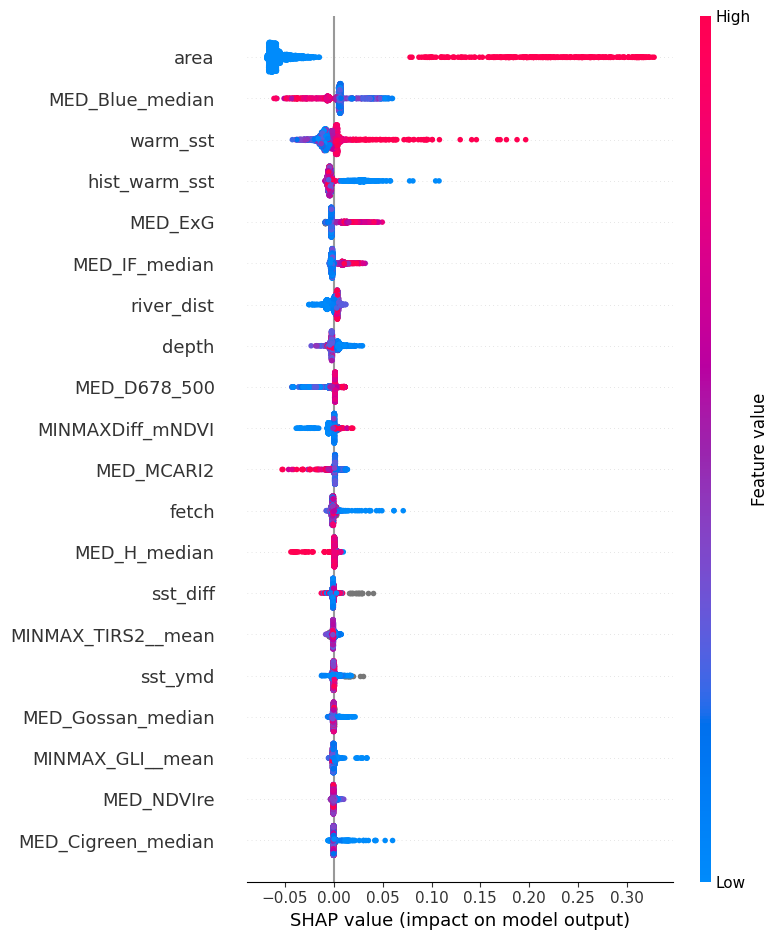

##############################
● CV1
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00180327
[1000]	valid_0's fair: 0.00169797
[1500]	valid_0's fair: 0.00165849
[2000]	valid_0's fair: 0.00164089
Did not meet early stopping. Best iteration is:
[1999]	valid_0's fair: 0.0016408
0.16373367728874344


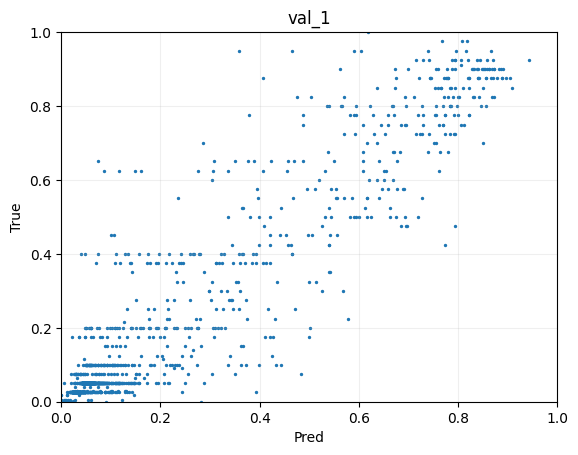

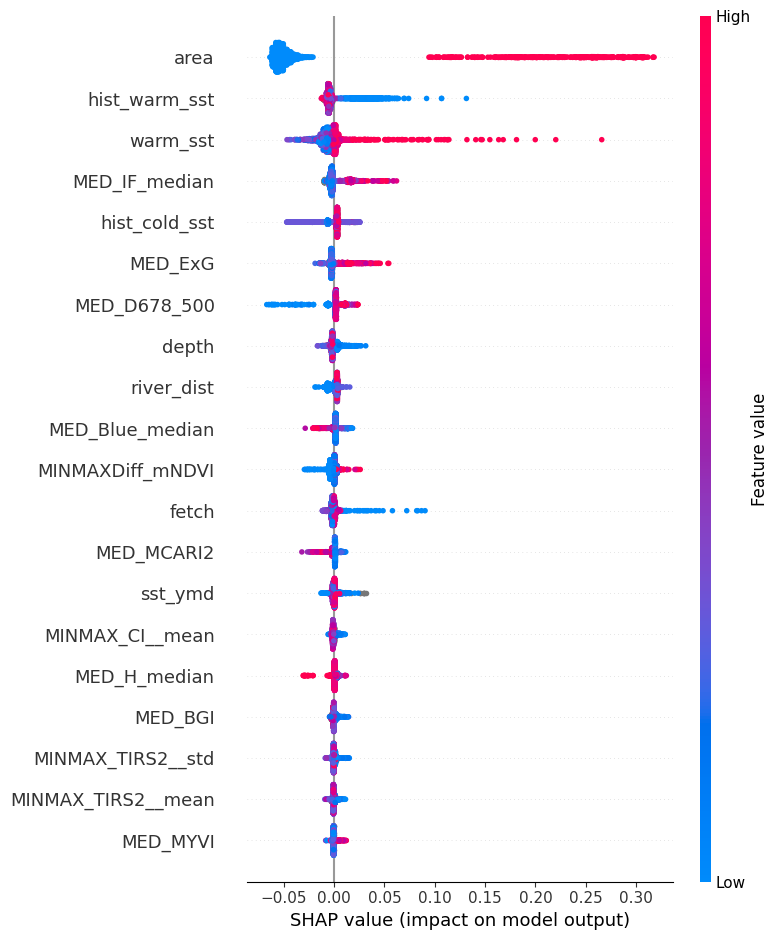

##############################
● CV2
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00185198
[1000]	valid_0's fair: 0.00175755
[1500]	valid_0's fair: 0.00171812
[2000]	valid_0's fair: 0.00169206
Did not meet early stopping. Best iteration is:
[2000]	valid_0's fair: 0.00169206
0.14863249833392095


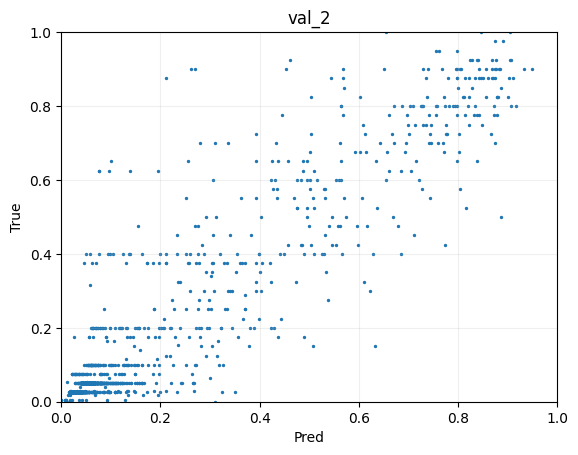

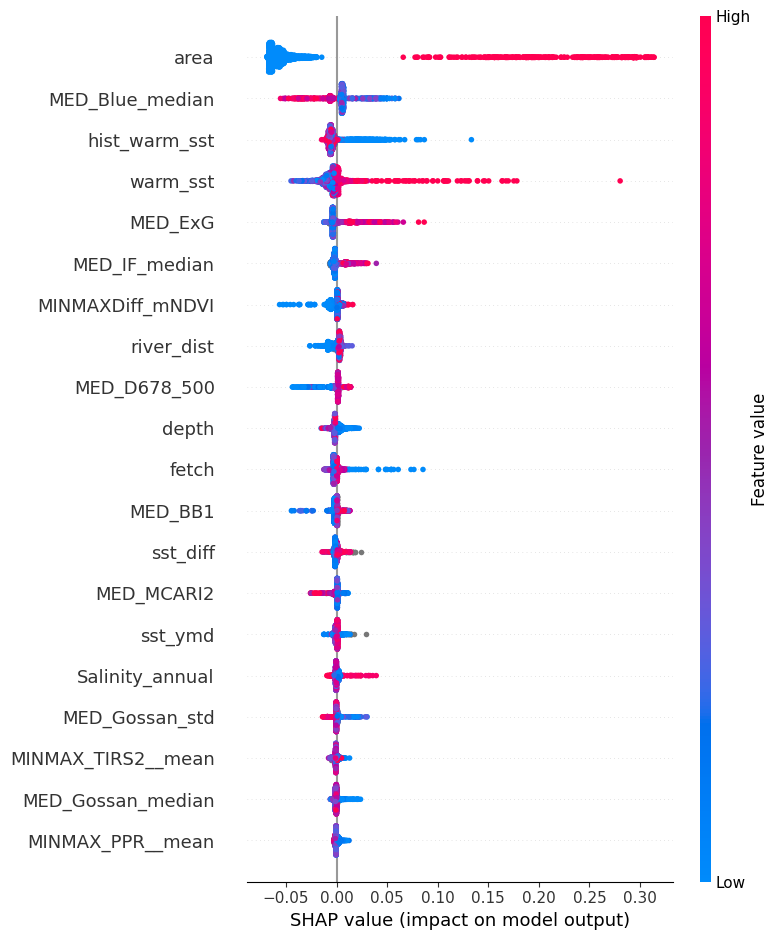

##############################
● CV3
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00189935
[1000]	valid_0's fair: 0.00182707
[1500]	valid_0's fair: 0.00179377
[2000]	valid_0's fair: 0.00178375
Did not meet early stopping. Best iteration is:
[2000]	valid_0's fair: 0.00178375
0.14836187711677518


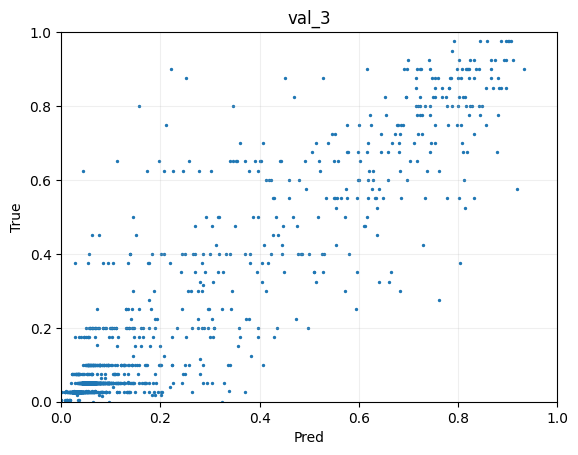

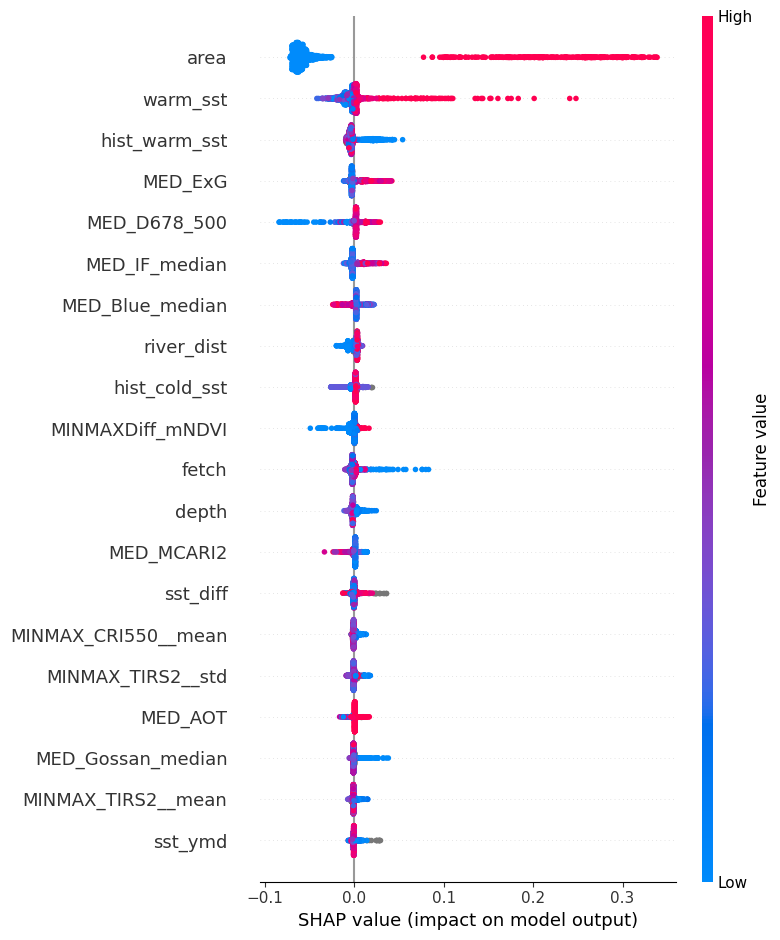

##############################
● CV4
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00172504
[1000]	valid_0's fair: 0.00162816
[1500]	valid_0's fair: 0.00159843
[2000]	valid_0's fair: 0.00157825
Did not meet early stopping. Best iteration is:
[2000]	valid_0's fair: 0.00157825
0.14847371647325


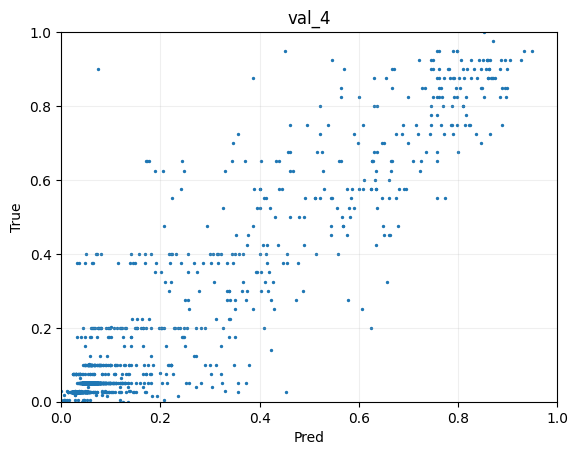

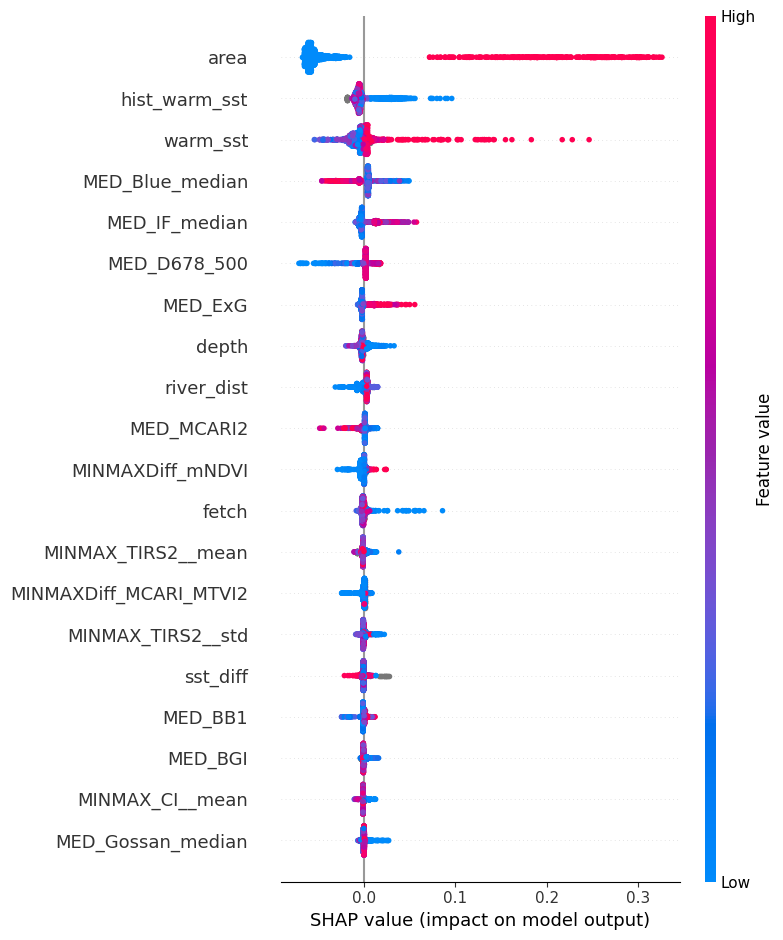

##############################
学習曲線
##############################


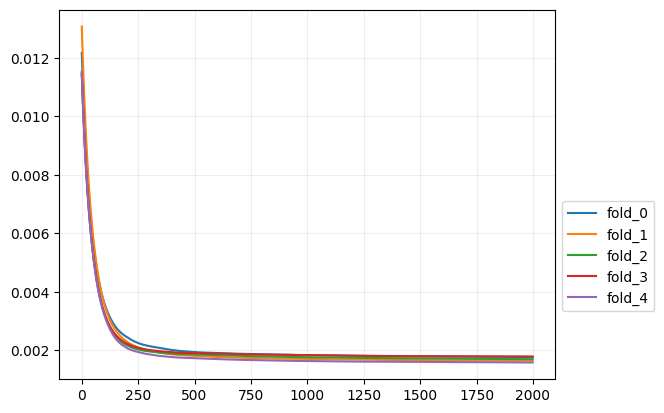

In [ ]:
idx_null_depth_original = train["depth_original"].isnull()
idx_null_depth_original_test = test["depth_original"].isnull()

train_mod = train[idx_null_depth_original]
test_mod = test[idx_null_depth_original_test]

results_rmse, fi_df, y_test_pred, y_val_pred = my_cross_val_predict(train_mod, test_mod, y_name="log_cover", y_raw_name="cover", params=params, features=features)

In [ ]:
y_test_pred_final[idx_null_depth_original_test.values] = y_test_pred
y_val_pred_final[idx_null_depth_original.values] = y_val_pred

CV0: 0.088
CV1: 0.083
CV2: 0.084
CV3: 0.087
CV4: 0.080
Average: 0.084


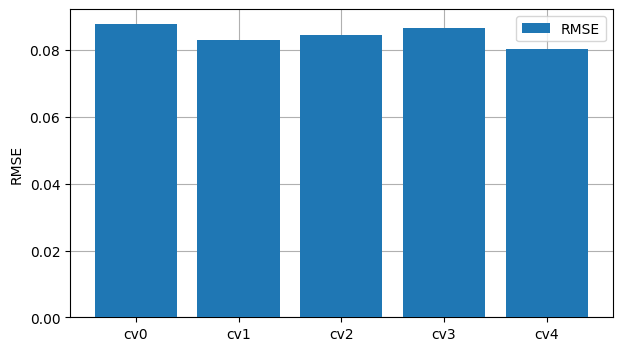

In [ ]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 437)


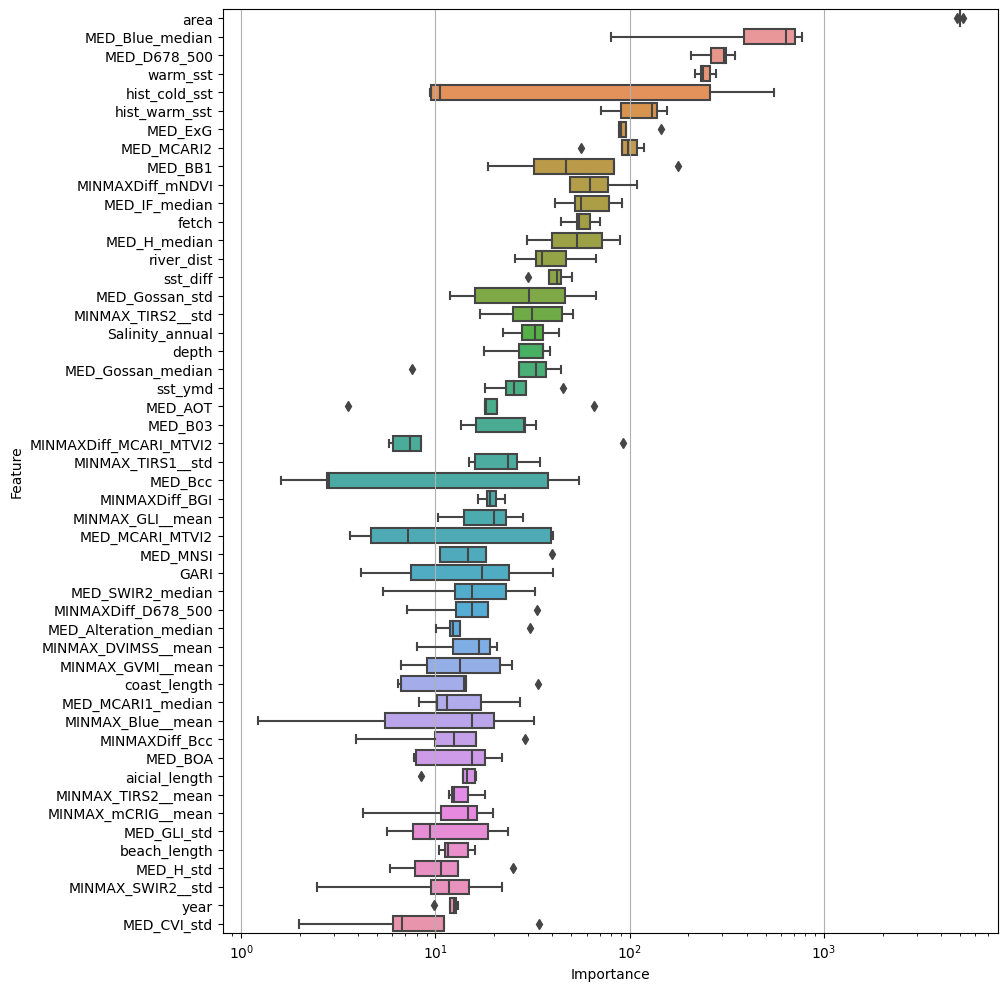

In [ ]:
plot_importance(fi_df, figsize=(10, 12))

## パターン2（depth_originalが欠損）

##############################
● CV0
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00568541
[1000]	valid_0's fair: 0.0052866
[1500]	valid_0's fair: 0.00513533
[2000]	valid_0's fair: 0.00505436
Did not meet early stopping. Best iteration is:
[1983]	valid_0's fair: 0.00505336
0.22257421803975413


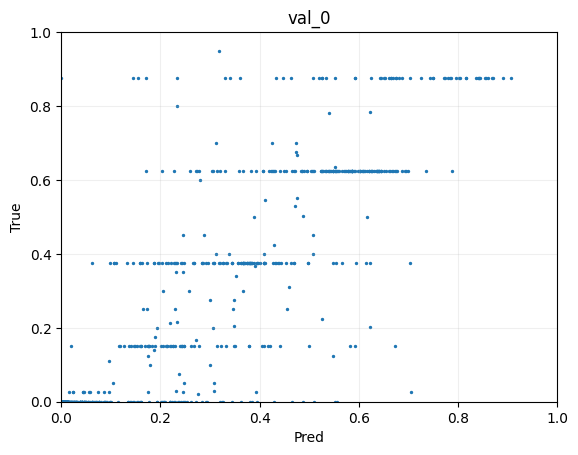

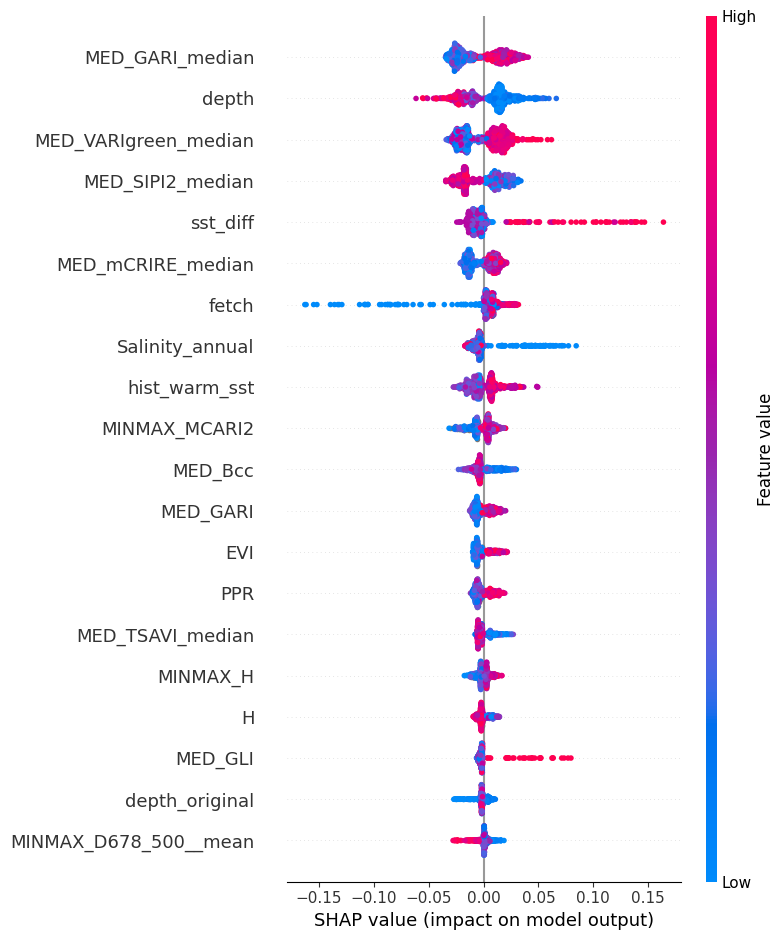

##############################
● CV1
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.0061382
[1000]	valid_0's fair: 0.00572317
[1500]	valid_0's fair: 0.00556693
[2000]	valid_0's fair: 0.00548245
Did not meet early stopping. Best iteration is:
[1998]	valid_0's fair: 0.00548206
0.23855975067620508


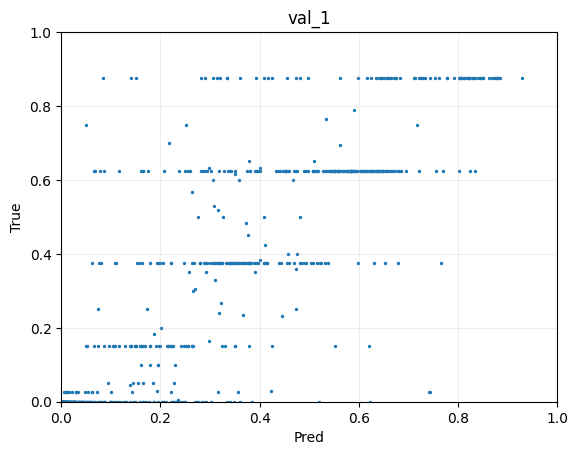

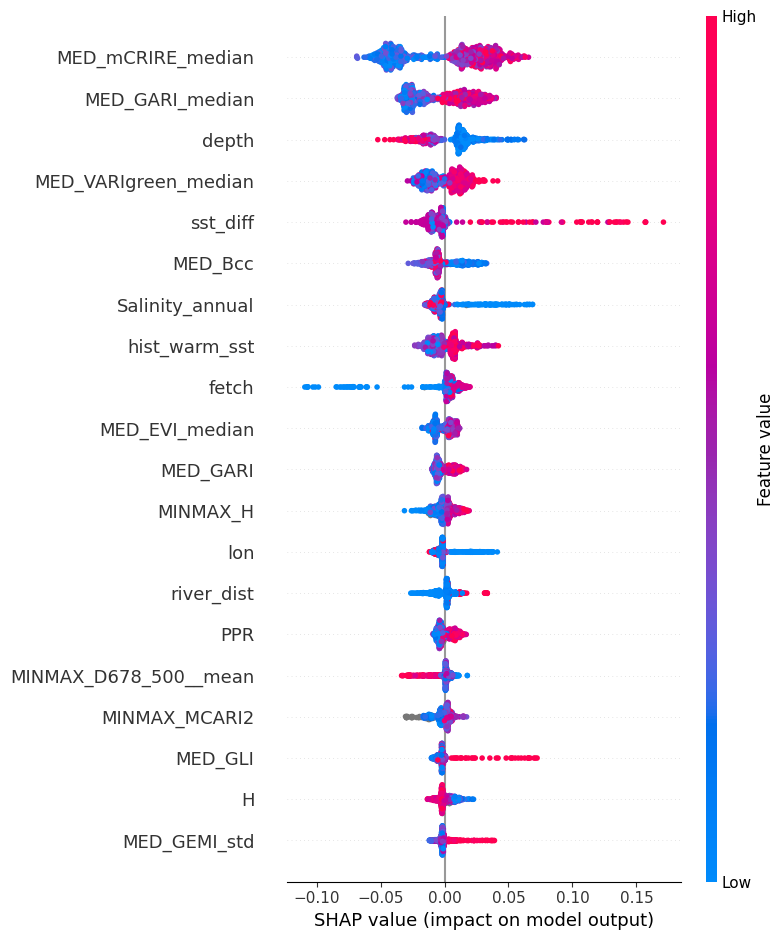

##############################
● CV2
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00571571
[1000]	valid_0's fair: 0.00523002
[1500]	valid_0's fair: 0.0050427
[2000]	valid_0's fair: 0.00495743
Did not meet early stopping. Best iteration is:
[2000]	valid_0's fair: 0.00495743
0.24168535990916853


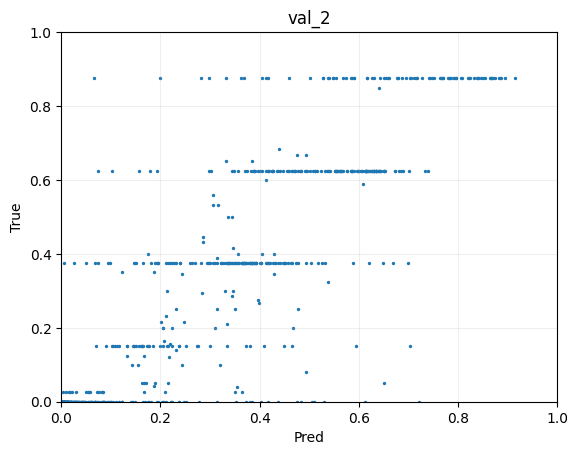

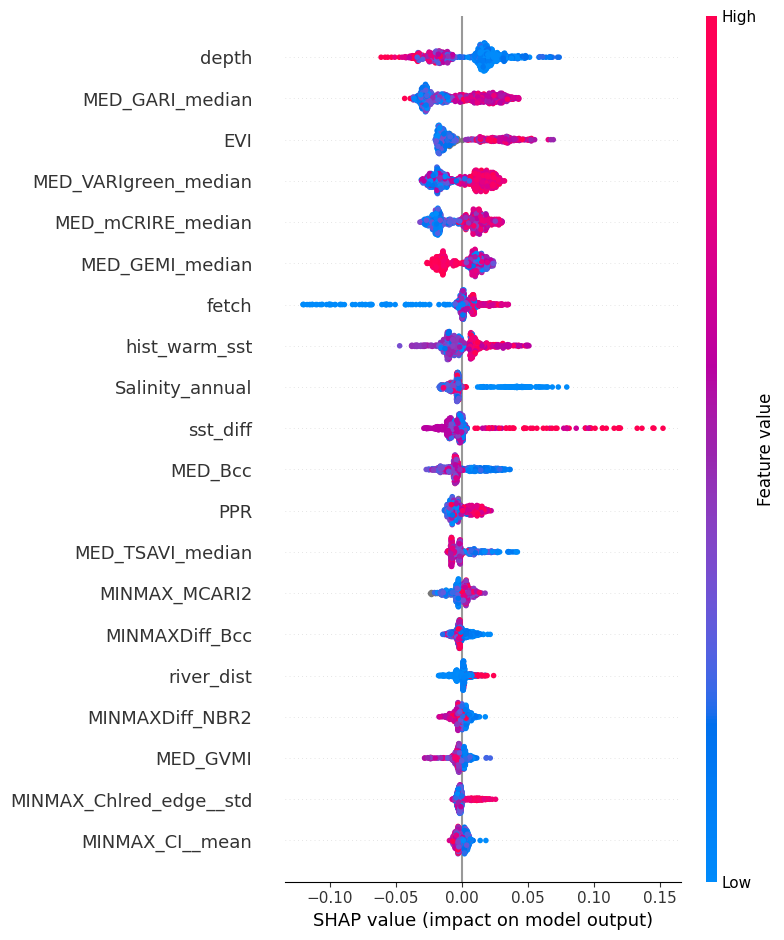

##############################
● CV3
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00627028
[1000]	valid_0's fair: 0.00572771
[1500]	valid_0's fair: 0.00550423
[2000]	valid_0's fair: 0.00536928
Did not meet early stopping. Best iteration is:
[2000]	valid_0's fair: 0.00536928
0.2468472000073447


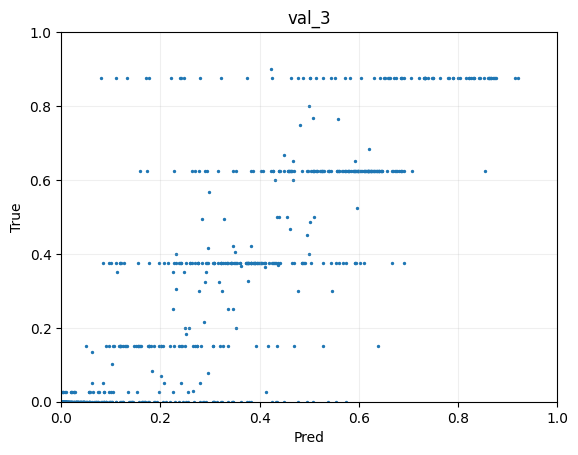

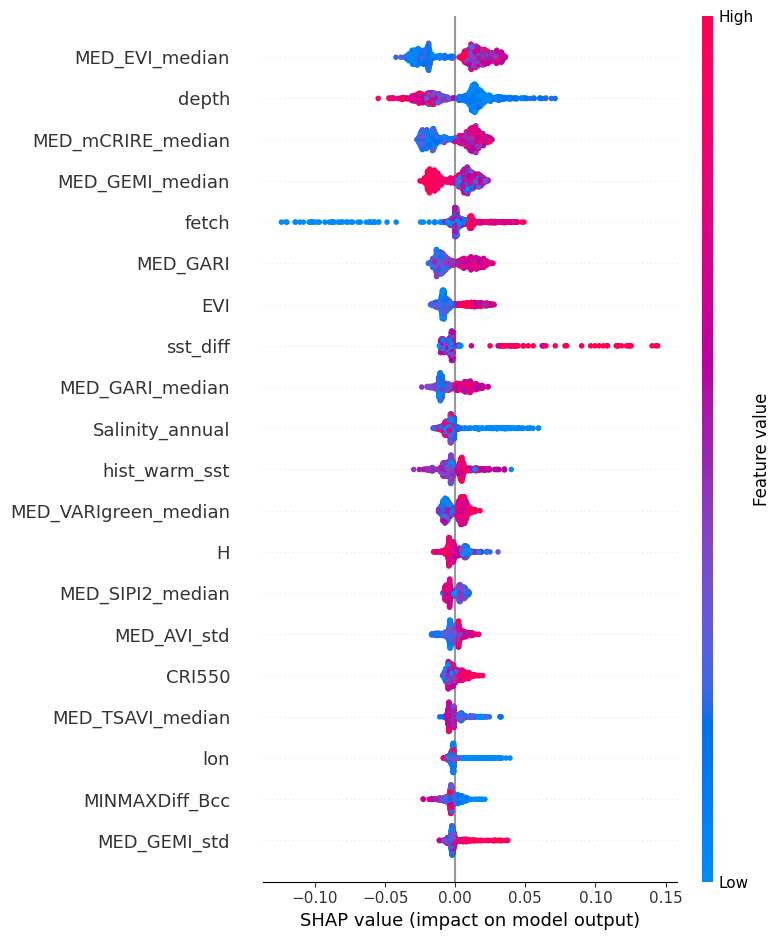

##############################
● CV4
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00550767
[1000]	valid_0's fair: 0.00503361
[1500]	valid_0's fair: 0.00490095
[2000]	valid_0's fair: 0.00483861
Did not meet early stopping. Best iteration is:
[1997]	valid_0's fair: 0.00483848
0.22822691708588858


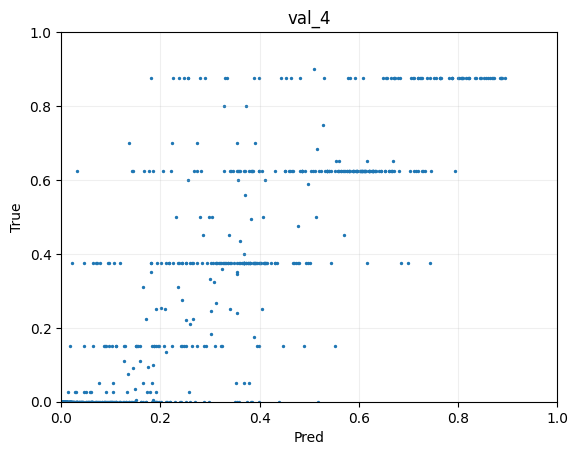

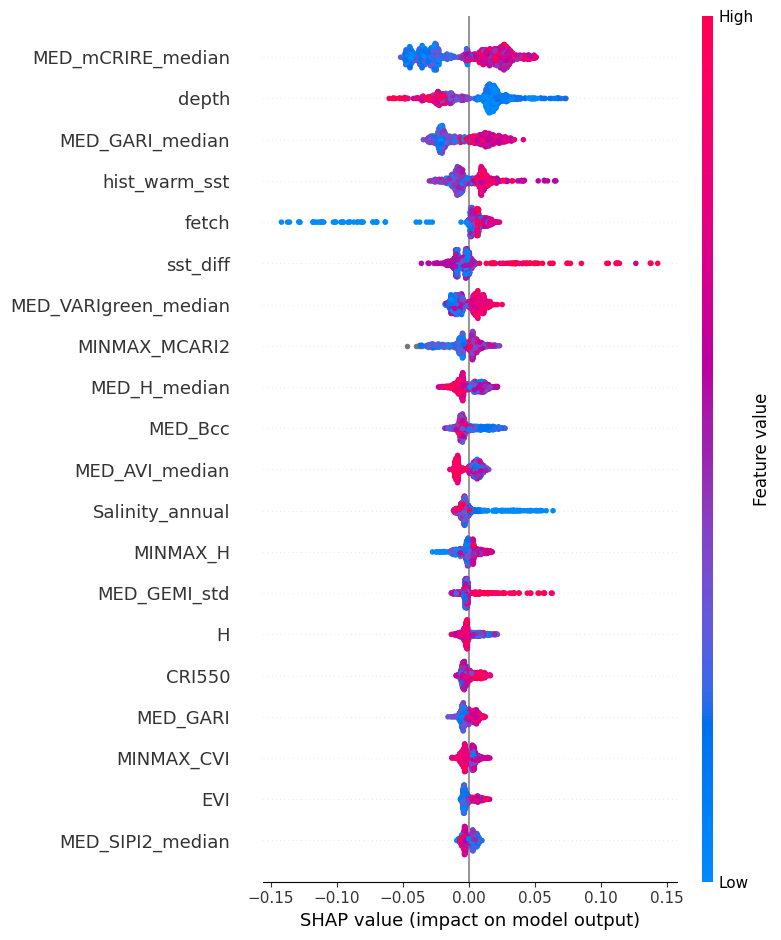

##############################
学習曲線
##############################


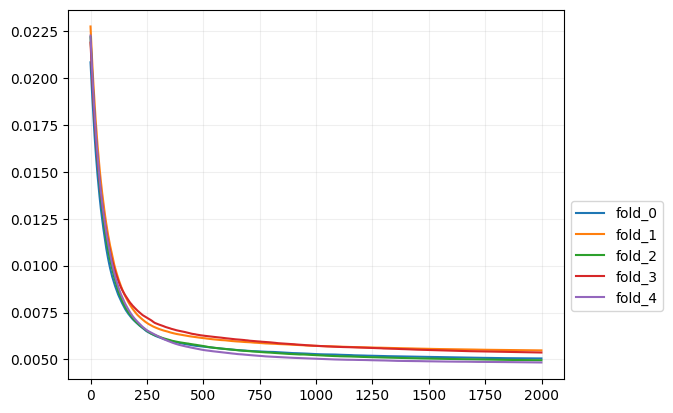

In [ ]:
idx_nonnull_depth_original = ~idx_null_depth_original
idx_nonnull_depth_original_test = ~idx_null_depth_original_test

train_mod = train[idx_nonnull_depth_original]
test_mod = test[idx_nonnull_depth_original_test]

results_rmse, fi_df, y_test_pred, y_val_pred = my_cross_val_predict(train_mod, test_mod, y_name="log_cover", y_raw_name="cover", params=params, features=features)

In [ ]:
y_test_pred_final[idx_nonnull_depth_original_test.values] = y_test_pred
y_val_pred_final[idx_nonnull_depth_original.values] = y_val_pred

CV0: 0.148
CV1: 0.157
CV2: 0.147
CV3: 0.153
CV4: 0.146
Average: 0.150


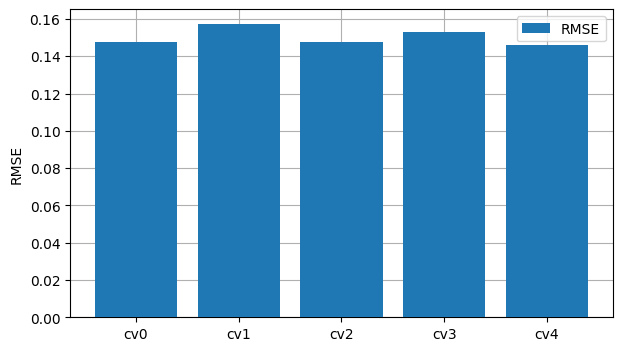

In [ ]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 437)


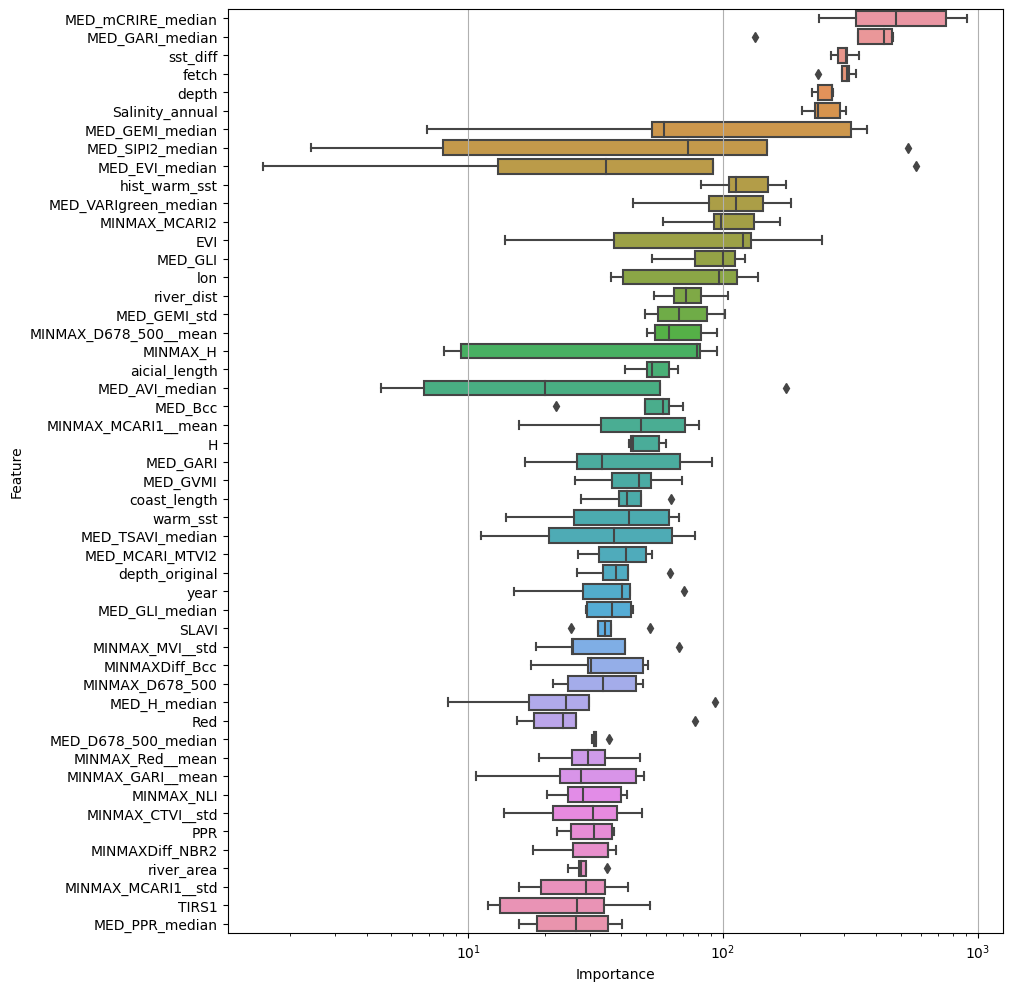

In [ ]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [ ]:
test_sub = pd.DataFrame(y_test_pred_final, columns=["pred"])
test_sub

,pred
0,0.299611
1,0.111318
2,0.257917
3,0.046399
4,0.087254
...,...
4034,0.122677
4035,0.047592
4036,0.243845
4037,0.044133


In [ ]:
test_pred_mean = test_sub["pred"].mean()
test_pred_mean

0.19311636302854332

In [ ]:
test_sub2 = test_sub.copy()
public_mean = 0.09088
# test_sub["pred"] = test_sub["pred"] * (public_mean / test_pred_mean)
test_sub2["pred"] -= (test_pred_mean - public_mean)
test_sub2["pred"] = np.clip(test_sub2["pred"].values, 0, 1)
test_sub2

,pred
0,0.197374
1,0.009082
2,0.155681
3,0.000000
4,0.000000
...,...
4034,0.020440
4035,0.000000
4036,0.141609
4037,0.000000


In [ ]:
print("pred_最小値:", test_sub["pred"].min())
print("pred_最大値:", test_sub["pred"].max())
print("pred_平均値:", test_sub["pred"].mean())

pred_最小値: 0.013152893439239376
pred_最大値: 0.8118936811613023
pred_平均値: 0.19311636302854332


In [ ]:
print("●後処理後")
print("pred_最小値:", test_sub2["pred"].min())
print("pred_最大値:", test_sub2["pred"].max())
print("pred_平均値:", test_sub2["pred"].mean())

●後処理後
pred_最小値: 0.0
pred_最大値: 0.709657318132759
pred_平均値: 0.1123627860661468


In [ ]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)
    test_sub2.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}_mod.csv", header=False)

# 予測結果確認

In [ ]:
train["y_pred"] = y_val_pred_final

In [ ]:
def check_by_scatter(check_col):
    tmp1 = df_pred[train[check_col].isnull()]
    tmp2 = df_pred[~train[check_col].isnull()]
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.grid(alpha=0.2, color="gray")
    ax.scatter(tmp2["y_pred"], tmp2["cover"], s=6, label=f"NOT Null", alpha=0.5)
    ax.scatter(tmp1["y_pred"], tmp1["cover"], s=6, label=f"Null", alpha=0.5)
    ax.set_xlabel("Pred")
    ax.set_ylabel("True")
    ax.set_title(check_col)
    ax.legend()
    plt.show()

In [ ]:
df_pred = train[["cover", "y_pred"]]
score = np.sqrt(mean_squared_error(train['cover'].values, train['y_pred'].values))
print(f"全体のRMSE: {score:.04f}")

全体のRMSE: 0.1095


●全体のRMSE (depth_originalがnull)
　データ数: 9721
　スコア: 0.0845

●全体のRMSE (depth_originalがnull以外)
　データ数: 4419
　スコア: 0.1504

テストデータでdepth_originalがnullの割合
　50.829%


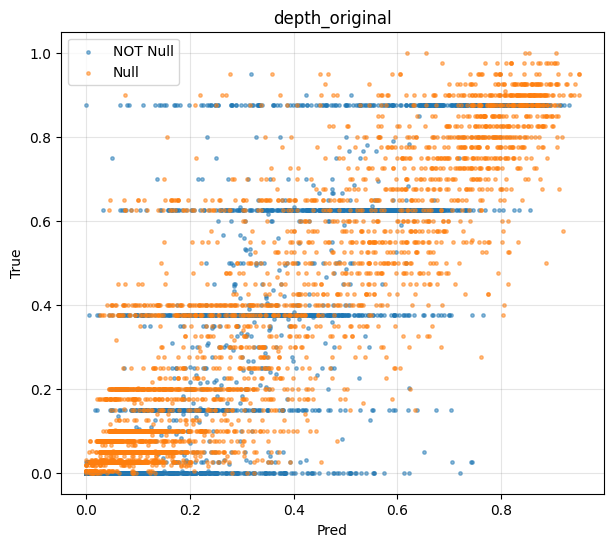

In [ ]:
check_col = "depth_original"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

●全体のRMSE (Blueがnull)
　データ数: 3582
　スコア: 0.1164

●全体のRMSE (Blueがnull以外)
　データ数: 10558
　スコア: 0.1070

テストデータでBlueがnullの割合
　27.804%


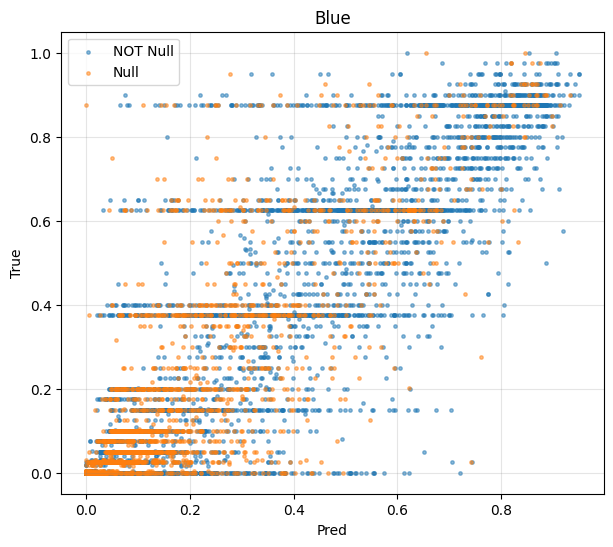

In [ ]:
check_col = "Blue"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

●全体のRMSE (MED_AFRI1600がnull)
　データ数: 291
　スコア: 0.0257

●全体のRMSE (MED_AFRI1600がnull以外)
　データ数: 13849
　スコア: 0.1105

テストデータでMED_AFRI1600がnullの割合
　0.545%


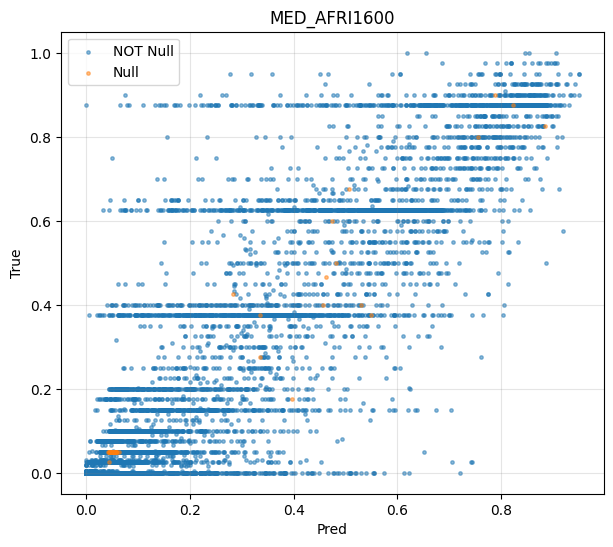

In [ ]:
check_col = "MED_AFRI1600"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [ ]:
check_col = "MAX_NormG__median"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

KeyError: ignored

In [ ]:
check_col = "depth"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

●全体のRMSE (Landsat_num==7)
　データ数: 7343
　スコア: 0.0869

●全体のRMSE (Landsat_num==8)
　データ数: 3215
　スコア: 0.1427

テストデータでLandsat_num==7の割合
　40.753%


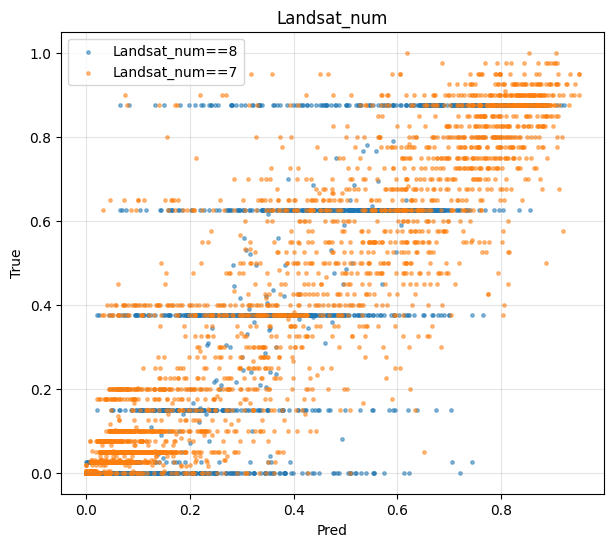

In [ ]:
check_col = "Landsat_num"
tmp1 = df_pred[train[check_col]==7]
tmp2 = df_pred[train[check_col]==8]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}==7)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}==8)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}==7の割合")
print(f"　{(100*(test[check_col]==7).sum()/len(test)):.3f}%")

fig, ax = plt.subplots(figsize=(7, 6))
ax.grid(alpha=0.2, color="gray")
ax.scatter(tmp2["y_pred"], tmp2["cover"], s=6, label=f"Landsat_num==8", alpha=0.5)
ax.scatter(tmp1["y_pred"], tmp1["cover"], s=6, label=f"Landsat_num==7", alpha=0.5)
ax.set_xlabel("Pred")
ax.set_ylabel("True")
ax.set_title(check_col)
ax.legend()
plt.show()+



In [ ]:
if SAVE_DF:
    train.to_pickle(SAVE_DF_DIR / f"train_predicted_{SUB_FILE_NAME}.pkl")